<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Data-and-Function-Preparation" data-toc-modified-id="Data-and-Function-Preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data and Function Preparation</a></span></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Random-Forest-Classifier" data-toc-modified-id="Random-Forest-Classifier-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Random Forest Classifier</a></span></li><li><span><a href="#Generalized-Additive-Models" data-toc-modified-id="Generalized-Additive-Models-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Generalized Additive Models</a></span></li></ul></div>

# 2.0 - Hit Probability
Predicting hits with Statcast data

## Libraries

In [1]:
import os

import pandas as pd
import numpy as np

from pandas_gbq import read_gbq

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score

from imblearn.under_sampling import RandomUnderSampler

from pygam import LogisticGAM
from pygam.utils import generate_X_grid

## Data

In [2]:
PROJECT_ID = 'ad-fantasy-baseball'
CREDENTIALS_PATH = os.path.join(os.pardir, './credentials/mlb-db-analysis-user.json')

In [3]:
params = {
    'year': '2017',
    'game_type': 'R'
}

In [4]:
SQL = \
"""
SELECT
  t_events.event_id AS event_id,
  t_events.batter_id AS batter_id,
  t_batter.mlb_name AS batter_name,
  t_events.pitcher_id AS pitcher_id,
  t_pitcher.mlb_name AS pitcher_name,
  t_events.at_bat_key AS at_bat_key,
  t_events.game_pk AS game_pk,
  t_events.at_bat_number AS at_bat_number,
  t_events.pitch_number AS pitch_number,
  t_events.batter_team AS batter_team,
  t_events.pitcher_team AS pitcher_team,
  t_events.batter_side AS batter_side,
  t_events.pitcher_side AS pitcher_side,
  t_events.description AS description,
  t_events.events AS events,
  t_events.bb_type AS bb_type,
  t_events.effective_speed AS effective_speed,
  t_events.release_speed AS release_speed,
  t_events.release_spin_rate AS release_spin_rate,
  t_events.release_pos_x AS release_pos_x,
  t_events.release_pos_z AS release_pos_z,
  t_events.break_horizontal AS break_horizontal,
  t_events.break_vertical AS break_vertical,
  t_events.zone AS zone,
  t_events.plate_x AS plate_x,
  t_events.plate_z AS plate_z,
  t_events.sz_top AS sz_top,
  t_events.sz_bot AS sz_bot,
  t_events.launch_speed AS launch_speed,
  t_events.launch_angle AS launch_angle,
  t_events.spray_angle AS spray_angle,
  t_events.hit_x AS hit_x,
  t_events.hit_y AS hit_y,
  t_events.hit_distance_sc AS hit_distance_sc,
  (CASE WHEN t_events.events IN ('single', 'double', 'triple', 'home_run') THEN 1 ELSE 0 END) AS hit_flag,
  (CASE WHEN t_events.events = 'home_run' THEN 1 ELSE 0 END) AS hr_flag,
  (CASE WHEN t_events.description IN ('foul', 'foul_tip', 'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score', 'pitchout_hit_into_play', 'pitchout_hit_into_play_score', 'swinging_pitchout', 'swinging_strike', 'swinging_strike_blocked')
    THEN 1 ELSE 0 END) AS swung_flag,
  (CASE WHEN t_events.events IS NOT NULL AND t_events.events NOT IN ('caught_stealing_2b', 'caught_stealing_3b', 'caught_stealing_home', 'pickoff_1b', 'pickoff_2b', 'pickoff_caught_stealing_2b', 'pickoff_caught_stealing_3b', 'pickoff_caught_stealing_home')
    THEN 1 ELSE 0 END) AS final_pitch_flag,
  (CASE WHEN t_events.launch_speed IS NOT NULL AND t_events.launch_angle IS NOT NULL AND t_events.hit_distance_sc IS NULL
    THEN 1 ELSE 0 END) AS sc_fill_flag
FROM
  (
    SELECT
      event_id,
      batter AS batter_id,
      pitcher AS pitcher_id,
      CONCAT(game_pk, CAST(at_bat_number AS STRING)) AS at_bat_key,
      game_pk,
      at_bat_number,
      pitch_number,
      MAX(batter_team) AS batter_team,
      MAX(pitcher_team) AS pitcher_team,
      MAX(stand) AS batter_side,
      MAX(p_throws) AS pitcher_side,
      MAX(description) AS description,
      MAX(events) AS events,
      MAX(bb_type) AS bb_type,
      MAX(effective_speed) AS effective_speed,
      MAX(release_speed) AS release_speed,
      MAX(release_spin_rate) AS release_spin_rate,
      MAX(release_pos_x) AS release_pos_x,
      MAX(release_pos_z) AS release_pos_z,
      MAX(pfx_x) AS break_horizontal,
      MAX(pfx_z) AS break_vertical,
      MAX(zone) AS zone,
      MAX(plate_x) AS plate_x,
      MAX(plate_z) AS plate_z,
      MAX(sz_top) AS sz_top,
      MAX(sz_bot) AS sz_bot,
      MAX(launch_speed) AS launch_speed,
      MAX(launch_angle) AS launch_angle,
      MAX(spray_angle_est) AS spray_angle,
      MAX(hc_x) AS hit_x,
      MAX(hc_y) AS hit_y,
      MAX(hit_distance_sc) AS hit_distance_sc
    FROM
      `ad-fantasy-baseball.core.statcast_extended`
    WHERE
      game_year = {year}
        AND game_type = '{game_type}'
    GROUP BY 1, 2, 3, 4, 5, 6, 7
  ) t_events
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id,
      mlb_name
    FROM
      `ad-fantasy-baseball.core.players`
    GROUP BY 1, 2
  ) t_batter
    ON (t_events.batter_id = t_batter.mlb_id)
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id,
      mlb_name
    FROM
      `ad-fantasy-baseball.core.players`
    GROUP BY 1, 2
  ) t_pitcher
    ON (t_events.pitcher_id = t_pitcher.mlb_id)
"""

In [5]:
sql = SQL.format(**params)
df_events = read_gbq(query=sql, dialect='standard', project_id=PROJECT_ID, private_key=CREDENTIALS_PATH)

df_true = df_events.copy()

In [6]:
df_events.head(5)

,event_id,batter_id,batter_name,pitcher_id,pitcher_name,at_bat_key,game_pk,at_bat_number,pitch_number,batter_team,...,launch_angle,spray_angle,hit_x,hit_y,hit_distance_sc,hit_flag,hr_flag,swung_flag,final_pitch_flag,sc_fill_flag
0,491310.1.4,445055,Jon Jay,623451,Jackson Stephens,4913101,491310,1,4,CHC,...,None,NaN,None,None,None,0,0,0,0,0
1,491778.38.1,445055,Jon Jay,621389,Ty Blach,49177838,491778,38,1,CHC,...,None,NaN,None,None,None,0,0,0,0,0
2,491906.59.7,445055,Jon Jay,519322,Drew Storen,49190659,491906,59,7,CHC,...,None,NaN,None,None,None,0,0,0,1,0
3,492461.1.3,445055,Jon Jay,608379,Michael Wacha,4924611,492461,1,3,CHC,...,None,NaN,None,None,None,0,0,0,0,0
4,490526.17.6,445055,Jon Jay,621107,Zach Eflin,49052617,490526,17,6,CHC,...,None,NaN,None,None,None,0,0,0,0,0


In [7]:
df_events.shape

(718923, 39)

## Data and Function Preparation
Creating sub-datasets and functions for later use.

In [8]:
num_cols = [
    'effective_speed',
    'release_speed',
    'release_spin_rate',
    'release_pos_x',
    'release_pos_z',
    'break_horizontal',
    'break_vertical',
    'zone',
    'plate_x',
    'plate_z',
    'sz_top',
    'sz_bot',
    'launch_speed',
    'launch_angle',
    'hit_x',
    'hit_y',
    'hit_distance_sc'
]

df_events[num_cols] = df_events[num_cols].apply(pd.to_numeric)

In [9]:
_batted = df_events['bb_type'].notnull()
_hit = df_events['hit_flag'] == 1
_swung = df_events['swung_flag'] == 1
_final = df_events['final_pitch_flag'] == 1
_sc_fill = df_events['sc_fill_flag'] == 1
_rhb = df_events['batter_side'] == 'R'
_lhb = df_events['batter_side'] == 'L'
_rhp = df_events['pitcher_side'] == 'R'
_lhp = df_events['pitcher_side'] == 'L'

In [44]:
df_events['same_side_flag'] = np.where(((_rhb & _rhp) | (_lhb & _lhp)), 1, 0)

df_events['adj_release_pos_x'] = np.where(_lhp, df_events.release_pos_x, -df_events.release_pos_x)
df_events['adj_break_horizontal'] = np.where(_lhp, df_events.break_horizontal, -df_events.break_horizontal)
df_events['adj_spray_angle'] = np.where(_lhb, df_events.spray_angle, -df_events.spray_angle)
df_events['adj_plate_x'] = np.where(_lhb, df_events.plate_x, -df_events.plate_x)

df_events['exp_launch_speed'] = np.exp(df_events.launch_speed)

df_events['log_launch_speed'] = np.log(df_events.launch_speed)

In [45]:
df_batted = df_events[_batted & ~_sc_fill]
df_hit = df_events[_hit & ~_sc_fill]
df_swung = df_events[_swung & ~_sc_fill]
df_final = df_events[_final & ~_sc_fill]
df_sof = df_events[(_swung | _final) & ~_sc_fill]
df_rhb = df_events[_rhb & ~_sc_fill]
df_lhb = df_events[_lhb & ~_sc_fill]
df_rhp = df_events[_rhp & ~_sc_fill]
df_lhp = df_events[_lhp & ~_sc_fill]
df_same_side = df_events[((_rhb & _rhp) | (_lhb & _lhp)) & ~_sc_fill]
df_oppo_side = df_events[((_rhb & _lhp) | (_lhb & _rhp)) & ~_sc_fill]

## Modeling

In [12]:
sns.set(rc={'figure.figsize':(16,9)})

### Generalized Additive Models
Modeling hit probability using GAMs

In [37]:
def fit_and_test_gam(df, x_labels, y_label, test_size=0.20, n_splines=10, under_sample=True):
    # Remove any NAs
    all_cols = x_labels + [y_label]
    _df = df[all_cols]
    _df = df.dropna(axis=0, how='any')

    # Define X and y arrays
    X = _df[x_labels]
    y = _df[y_label]
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1, stratify=y)
    
    if under_sample:
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_resample(X_train, y_train)
    
    # Train the model
    gam = LogisticGAM(n_splines=n_splines)
    gam.gridsearch(X_train, y_train)
     
    # Plot Individual features
    XX = generate_X_grid(gam)
    plt.rcParams['figure.figsize'] = (28, 8)
    fig, axs = plt.subplots(1, len(x_cols))
    titles = x_cols
    for i, ax in enumerate(axs):
        pdep, confi = gam.partial_dependence(XX, feature=i+1, width=.95)
        ax.plot(XX[:, i], pdep)
        ax.plot(XX[:, i], confi[0][:, 0], c='grey', ls='--')
        ax.plot(XX[:, i], confi[0][:, 1], c='grey', ls='--')
        ax.set_title(titles[i])
    plt.show()

    # Test the model against the held over test set
    y_pred = gam.predict(X_test)
    y_pred_proba = gam.predict_proba(X_test)
    
    # Model metrics
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nPrecision Score:")
    print(precision_score(y_test, y_pred))
    
    print("\nRecall Score:")
    print(recall_score(y_test, y_pred))
    
    print("\nF1 Score:")
    print(f1_score(y_test, y_pred))
    
    print("\nROC AUC Score:")
    print(roc_auc_score(y_test, y_pred_proba))
    
    return gam

100% (11 of 11) |########################| Elapsed Time: 0:00:12 Time:  0:00:12


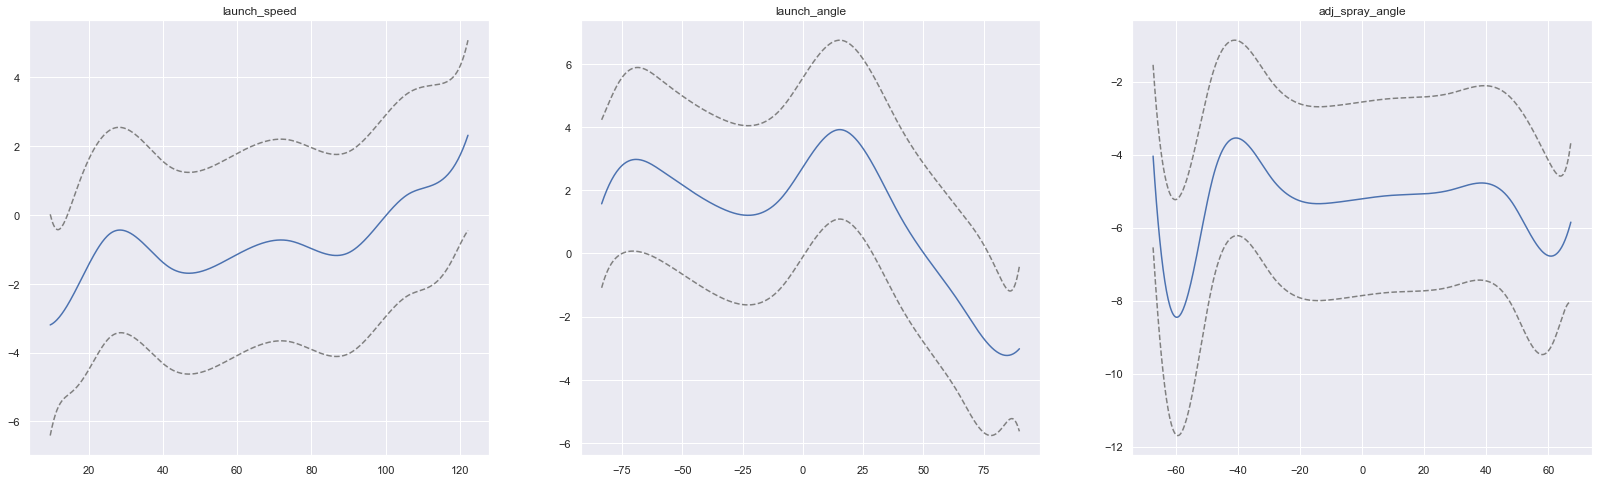


Confusion Matrix:
[[10235  4187]
 [ 1490  6355]]

Precision Score:
0.6028267880857522

Recall Score:
0.8100701083492671

F1 Score:
0.6912492521890465

ROC AUC Score:
0.8238972149606077


In [39]:
x_cols = [
    'launch_speed',
    'launch_angle',
    'adj_spray_angle'
]
y_col = 'hit_flag'

hit_gam = fit_and_test_gam(df_batted, x_labels=x_cols, y_label=y_col, n_splines=10)

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/pygam/pygam.py:941: RuntimeWarning: overflow encountered in square
  self.distribution.V(mu=mu) *
  9% (1 of 11) |##                       | Elapsed Time: 0:00:08 ETA:   0:01:23/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/pygam/pygam.py:941: RuntimeWarning: overflow encountered in square
  self.distribution.V(mu=mu) *
 18% (2 of 11) |####                     | Elapsed Time: 0:00:10 ETA:   0:00:45/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/pygam/pygam.py:941: RuntimeWarning: overflow encountered in square
  self.distribution.V(mu=mu) *
100% (11 of 11) |########################| Elapsed Time: 0:00:28 Time:  0:00:28


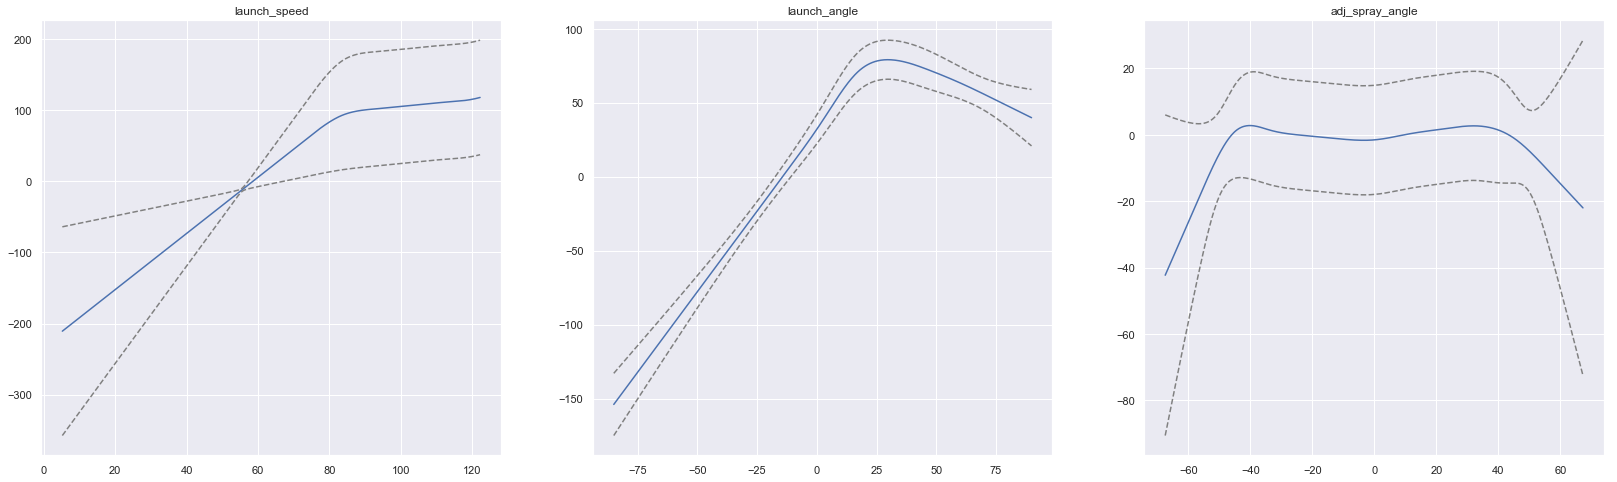


Confusion Matrix:
[[20899   209]
 [  304   855]]

Precision Score:
0.8035714285714286

Recall Score:
0.7377049180327869

F1 Score:
0.7692307692307693

ROC AUC Score:
0.9913704007640233


In [40]:
x_cols = [
    'launch_speed',
    'launch_angle',
    'adj_spray_angle'
]
y_col = 'hr_flag'

hr_gam = fit_and_test_gam(df_batted, x_labels=x_cols, y_label=y_col, n_splines=15, under_sample=False)

In [71]:
hit_gam.predict_proba([[90.0, 10.0, -0.0]])

array([0.59931692])

100% (11 of 11) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


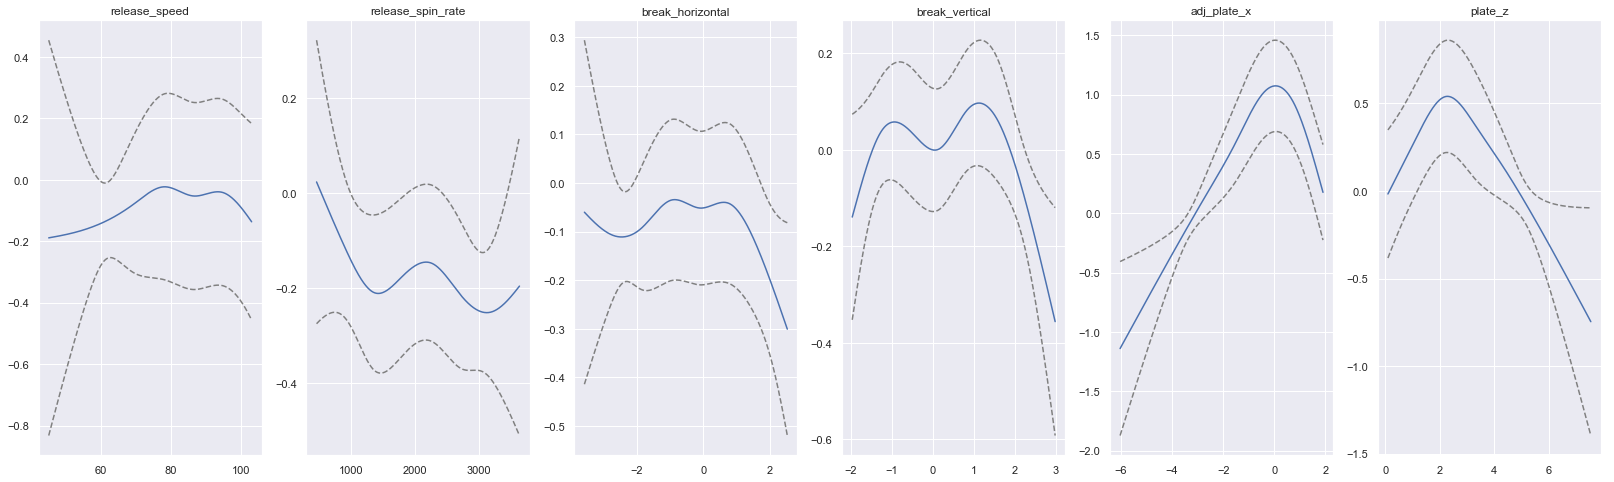


Confusion Matrix:
[[6537 7885]
 [3074 4771]]

Precision Score:
0.37697534766118834

Recall Score:
0.6081580624601657

F1 Score:
0.4654407102092581

ROC AUC Score:
0.5427349548026928


In [47]:
x_cols = [
    'release_speed',
    'release_spin_rate',
    'break_horizontal',
    'break_vertical',
    'adj_plate_x',
    'plate_z'
]
y_col = 'hit_flag'

hit_pitch_gam = fit_and_test_gam(df_sof, x_labels=x_cols, y_label=y_col, n_splines=10)